In [294]:
import matplotlib.pyplot as plt 
import matplotlib
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import math

# disable this when not using Google Colab
from google.colab import drive
drive.mount('/content/drive')
drive_prefix = 'drive/My Drive/Andmeteadus2019projekt/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# drive_prefix = 'drive/My Drive/Andmeteadus2019projekt/'
# data4 = pd.read_csv(drive_prefix + "finaldata13dets.csv", sep=',', index_col=0, na_values='')


# #reading in all csv files
data1 = pd.read_csv(drive_prefix + "liiklusjarelevalve_1.csv", sep='\t', index_col=0, na_values='')
data2 = pd.read_csv(drive_prefix + "liiklusjarelevalve_2.csv", sep='\t', index_col=0, na_values='')
data3 = pd.read_csv(drive_prefix + "liiklusjarelevalve_3.csv", sep='\t', index_col=0, na_values='')

# #concatenating data together and dropping duplicates (data from this year and last five years overlap)
data4 = pd.concat([data1, data2, data3]).drop_duplicates()

# #dropping irrelevant columns
columns_to_drop = ['RikkujaElukoht', 'Loige', 'Punkt', 'RikutudOigusnorm']
data4 = data4.drop(columns=columns_to_drop, axis=1)



# #Filling all nan values with a mode value (appears most often)

data4 = data4.fillna(data4.mode().iloc[0])

data4["Lest_X_Y"] = data4["Lest_X"].map(str) + " " + data4["Lest_Y"].map(str)



In [0]:

def cleanString(coords):
  output = coords.split(" ")
  for i, el in enumerate(output):
    if "-" in el:
      output[i] = el.split("-")[0]
    output[i] = int(output[i])
  return output
  
# function that was converted from PHP code to python. At first I tried to use maaamet.ee converter over API but it was too slow to work with it
# all credits go to maaamet.ee for this function

def lest_geo(x_y_list):
  a = 6378137
  F = 1 / 298.257222100883
  ESQ = F + F - F * F
  B0 = (57 + 31 / 60 + 3.194148 / 3600) / 57.2957795130823
  L0 = 24 / 57.2957795130823
  FN = 6375000
  FE = 500000
  B2 = (59 + 20 / 60) / 57.2957795130823
  B1 = 58 / 57.2957795130823
  xx = x_y_list[0] - FN
  yy = x_y_list[1] - FE
  t0 = math.sqrt((1 - math.sin(B0)) / (1 + math.sin(B0)) * ((1 + math.sqrt(ESQ) * math.sin(B0)) / (1 - math.sqrt(ESQ) * math.sin(B0))) ** math.sqrt(ESQ))
  t1 = math.sqrt((1 - math.sin(B1)) / (1 + math.sin(B1)) * ((1 + math.sqrt(ESQ) * math.sin(B1)) / (1 - math.sqrt(ESQ) * math.sin(B1))) ** math.sqrt(ESQ))
  t2 = math.sqrt((1 - math.sin(B2)) / (1 + math.sin(B2)) * ((1 + math.sqrt(ESQ) * math.sin(B2)) / (1 - math.sqrt(ESQ) * math.sin(B2))) ** math.sqrt(ESQ))
  m1 = math.cos(B1) / (1 - ESQ * math.sin(B1) * math.sin(B1)) ** 0.5
  m2 = math.cos(B2) / (1 - ESQ * math.sin(B2) * math.sin(B2)) ** 0.5
  n1 = (math.log(m1) - math.log(m2)) / (math.log(t1) - math.log(t2))
  FF = m1 / (n1 * t1 ** n1)
  p0 = a * FF * t0 ** n1
  p = (yy * yy + (p0 - xx) * (p0 - xx)) ** 0.5
  t = (p / (a * FF)) ** (1 / n1)
  FII = math.atan(yy / (p0 - xx))
  LON = FII / n1 + L0
  u = (math.pi / 2) - (2 * math.atan(t))
  LAT = (u + (ESQ / 2 + (5 * ESQ ** 2 / 24) + (ESQ ** 3 / 12) + (13 * ESQ ** 4 / 360)) * math.sin(2 * u) + ((7 * ESQ ** 2 / 48) + (29 * ESQ ** 3 / 240) + (811 * ESQ ** 4 / 11520)) * math.sin(4 * u) + ((7 * ESQ ** 3 / 120) + (81 * ESQ ** 4 / 1120)) * math.sin(6 * u) + (4279 * ESQ ** 4 / 161280) * math.sin(8 * u))
  LAT = LAT * 57.2957795130823
  LON = LON * 57.2957795130823

  return [LAT, LON]


# converting Lest coordinates to Geo coordinates 
data4['Geo_X_Y'] = data4['Lest_X_Y'].apply(lambda x: lest_geo(cleanString(x)))



In [0]:
# splitting column Geo_X_Y to two seperate columns
data5 = pd.DataFrame(data4.Geo_X_Y.tolist(), columns=['Geo_X', 'Geo_Y'])
data4["Geo_X"] = data5["Geo_X"].values
data4["Geo_Y"] = data5["Geo_Y"].values


In [0]:
# data on top5 counties from year 2018
kpv = data4.loc[data4["ToimKpv"].str.contains(pat = '2018')]

Harju = kpv.loc[kpv["MaakondNimetus"] == "Harju maakond"]
Tartu = kpv.loc[kpv["MaakondNimetus"] == "Tartu maakond"]
Pärnu = kpv.loc[kpv["MaakondNimetus"] == "Pärnu maakond"]
LääneViru = kpv.loc[kpv["MaakondNimetus"] == "Lääne-Viru maakond"]
IdaViru = kpv.loc[kpv["MaakondNimetus"] == "Ida-Viru maakond"]

# counties
maakonnad = [Harju, Tartu,Pärnu, LääneViru,  IdaViru]


In [0]:
#function to get the county's correct name 
def name(data):
    name =[x for x in globals() if globals()[x] is data][0]
    return name

In [0]:
# top 5 counties misdemeanours per person calculation
#  *ela means this county's population
#  *õnn means this county's misdemeanours per person ratio
# inimeseKohtaÕnnetused is an array of all the misdemeanours' ratios 
harjuela = 589610
harjuõnn = Harju.count()[0] /harjuela

tartuela = 93124
tartuõnn = Tartu.count()[0] /tartuela

idaviruela = 143880
idaviruõnn = IdaViru.count()[0] / idaviruela

pärnuela = 39620
pärnuõnn = Pärnu.count()[0] / pärnuela

LääneViruela = 58856
lääneviruõnn = LääneViru.count()[0] / LääneViruela

inimeseKohtaÕnnetused = [harjuõnn, tartuõnn,pärnuõnn,lääneviruõnn,idaviruõnn]

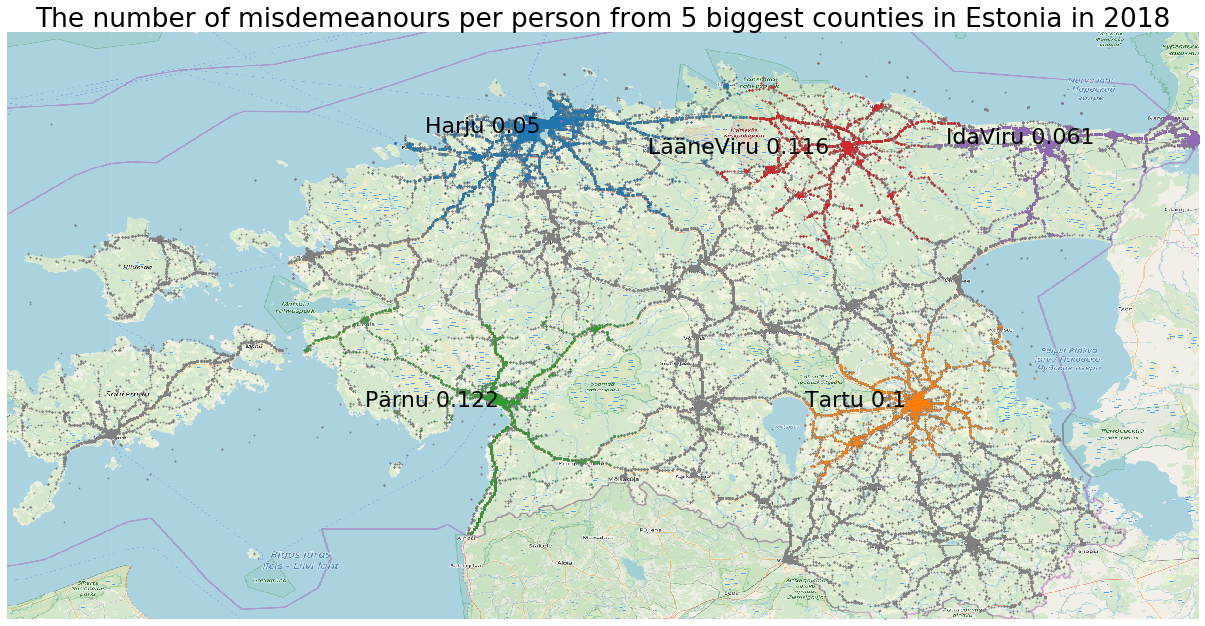

In [301]:

fig, ax = plt.subplots(figsize = (21.35,15.38)) #respective to image's aspect ratio

# scatter other counties' points
plt.scatter(data4.Geo_Y, data4.Geo_X, zorder=1, c='gray', s=0.5)

plt.rcParams.update({'font.size': 22})
# scatter top 5 counties' points
for i in range(len(maakonnad)):
  ax.scatter(maakonnad[i]["Geo_Y"],maakonnad[i]["Geo_X"], s=0.5, marker="o")
  ax.text(maakonnad[i]["Geo_Y"].mean(),maakonnad[i]["Geo_X"].mean(), str(name(maakonnad[i])) + " " +  str(round(inimeseKohtaÕnnetused[i], 3)),horizontalalignment='right')

ax.set_title('The number of misdemeanours per person from 5 biggest counties in Estonia in 2018')


#map of estonia 
est = plt.imread(drive_prefix + "map2.png")

#hiding x and y axis
plt.axis('off')
# showing plot on correct latitude and longitude coordinates and with correct aspect ratio
plt.imshow(est, extent=[21.946,28.199, 57.549, 59.779],  aspect=1.38)


In [0]:
data4 = data4.drop(columns=["Lest_X", "Lest_Y", "Lest_X_Y", "Geo_X_Y"])
#dropping unecessary columns

In [304]:
# displaying our dataset
data4

,ToimKpv,ToimKell,ToimNadalapaev,Seadus,Paragrahv,ParagrahvTais,MaakondNimetus,ValdLinnNimetus,KohtNimetus,MntVoiTanav,MntTanavNimetus,KM,SoidukLiik,SoidukRegRiik,SoidukMark,SoidukVlAasta,RikkujaSugu,RikkujaVanus,SyyteoLiik,Geo_X,Geo_Y
JuhtumId,,,,,,,,,,,,,,,,,,,,,
2fd44f1c-6370-18d7-888c-967f31fec8f0,2019-11-06,23:50,Kolmapäev,Liiklusseadus,§ 227.,§ 227. Mootorsõidukijuhi poolt lubatud sõiduki...,Harju maakond,Tallinn,Haabersti linnaosa,TNV,Paldiski mnt,1.0,SOIDUAUTO,EST,HONDA,2007,M,35-44,VT,59.428107,24.678289
2fd44ee0-6370-18d7-888c-967f31fec8f0,2019-11-06,18:19,Kolmapäev,Liiklusseadus,§ 242.,§ 242. Mootorsõiduki- või trammijuhi poolt lii...,Pärnu maakond,Pärnu linn,Pärnu linn,TNV,Tallinna mnt,1.0,SOIDUAUTO,EST,AUDI,2007,M,26-34,VT,58.391981,24.495884
2fd44ecc-6370-18d7-888c-967f31fec8f0,2019-11-06,18:16,Kolmapäev,Liiklusseadus,§ 227.,§ 227. Mootorsõidukijuhi poolt lubatud sõiduki...,Ida-Viru maakond,Toila vald,Kaasikaia küla,TNV,TALLINN - TARTU - VÕRU - LUHAMAA (2),1.0,VEOAUTO,EST,FORD,2016,M,55-64,VT,59.415772,27.285811
2fd44ec2-6370-18d7-888c-967f31fec8f0,2019-11-06,18:08,Kolmapäev,Liiklusseadus,§ 242.,§ 242. Mootorsõiduki- või trammijuhi poolt lii...,Pärnu maakond,Pärnu linn,Pärnu linn,TNV,Tallinna mnt,1.0,SOIDUAUTO,EST,BMW,2008,M,26-34,VT,58.392014,24.487334
2fd44eae-6370-18d7-888c-967f31fec8f0,2019-11-06,17:55,Kolmapäev,Liiklusseadus,§ 227.,§ 227. Mootorsõidukijuhi poolt lubatud sõiduki...,Harju maakond,Tallinn,Haabersti linnaosa,TNV,Rannamõisa tee,1.0,VEOAUTO,EST,ŠKODA,2018,M,35-44,VT,59.423839,24.634164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95dfdfb2-1636-18d5-8326-a9a756483dba,2012-01-01,01:00,Pühapäev,Liiklusseadus,§ 236.,§ 236. Liiklusõnnetusest mitteteatamine,Harju maakond,Tallinna linn,Kesklinna linnaosa,TNV,Estonia pst,1.0,SOIDUAUTO,EST,MERCEDES-BENZ,1998,M,45-54,VT,59.432213,24.748854
95dfe0b6-1636-18d5-8326-a9a756483dba,2012-01-01,00:52,Pühapäev,Liiklusseadus,§ 227.,§ 227. Mootorsõidukijuhi poolt lubatud sõiduki...,Harju maakond,Tallinna linn,Lasnamäe linnaosa,TNV,Peterburi tee,1.0,SOIDUAUTO,EST,AUDI,1997,M,35-44,VT,59.427195,24.836836
95dfdf9e-1636-18d5-8326-a9a756483dba,2012-01-01,00:20,Pühapäev,Liiklusseadus,§ 224.,"§ 224. Mootorsõiduki, maastikusõiduki või tram...",Jõgeva maakond,Torma vald,Torma vald,MNT,TORMA - KIVIJÄRVE (14117),4.0,SOIDUAUTO,EST,VOLKSWAGEN,1995,M,55-64,VT,58.805224,26.673912
